# Distribution Discrepancies Using Chi Square Test

- This Module Analyze Chi-Square discerpency using pageload data.
- Taken from 'Python for Data Analysis'.
- First check if:
    - If Statistic >= Critical Value: significant result, reject null hypothesis (H0), populations are different. Make sure P <= 0.5.
    - If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.
- If first test shows that populations are different, check which dimension is causing it. Remove dimension value one by one and check if test still shows different populations.
- If we like to hide Redshift credentials we can use Athena instead:
https://aws.amazon.com/blogs/machine-learning/run-sql-queries-from-your-sagemaker-notebooks-using-amazon-athena/.

In [1]:
#Read Redshift credentials
import boto3
import base64
from botocore.exceptions import ClientError
import ast

def get_secret():

    secret_name = "GBRedshiftSecret"
    region_name = "us-east-2"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
          # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return(secret)
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return(decode_binary_secret)

secret = get_secret()
USER = ast.literal_eval(secret)['username']
PASSWORD = ast.literal_eval(secret)['password']
HOST = ast.literal_eval(secret)['host']

## Read data from Redshift

In [ ]:
import scipy.stats as stats
import pandas as pd
import psycopg2
from datetime import datetime
import time
import uuid
import matplotlib.pyplot as plt

url_string = f"dbname='prod' port=5439 user='{USER}' password='{PASSWORD}' host='{HOST}'"
con = psycopg2.connect(url_string)
print(time.ctime(), "Redshift connection Successful!")
cur = con.cursor()
funnel_step_begin = 1
funnel_step_end = 4

print(f'Reading sessions from cs_table.')
sqlmsg = f'select session_uuid, funnel_step, uabrowser_group, resolution_family, uadevicetype, vendor, country, os \
           from cs_score \
           order by random() \
           limit 10000;'
           #where session_ts >= {t1} and funnel_step > 0;'
cur.execute(sqlmsg)
page = pd.DataFrame(cur.fetchall())
page.columns = ['SESSION_UUID', 'funnel_step', 'uabrowser_group', 'resolution_family', 'uadevicetype', 'vendor', 'country', 'os']
page.funnel_step.fillna(0, inplace=True)
page.funnel_step = page.funnel_step.apply(int)
page.head()

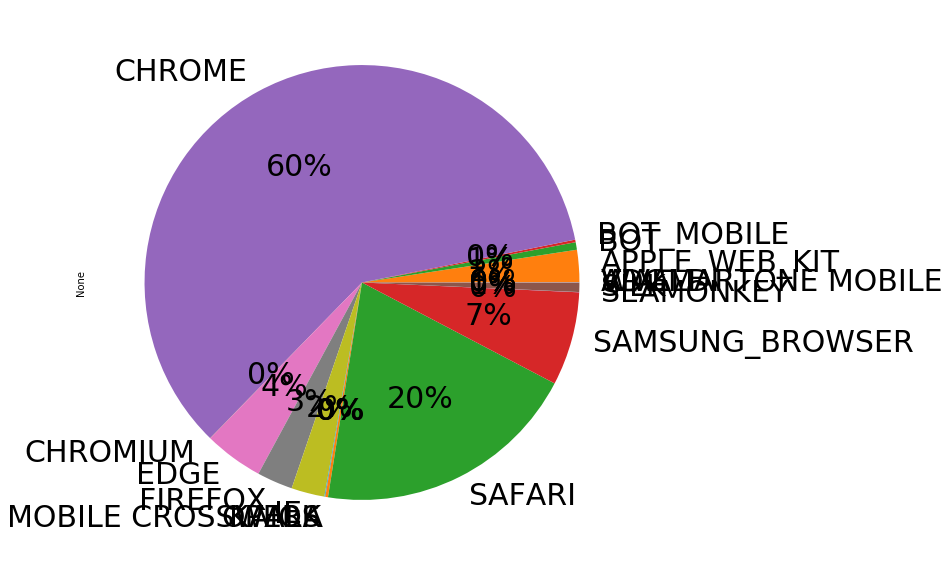

In [4]:
browser_df = page.groupby('uabrowser_group').size()
browser_df.columns = ['num']
ax = browser_df.plot.pie(y='num', figsize=(20,10), fontsize=30, autopct='%1.f%%')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216541DF0B8>]],
      dtype=object)

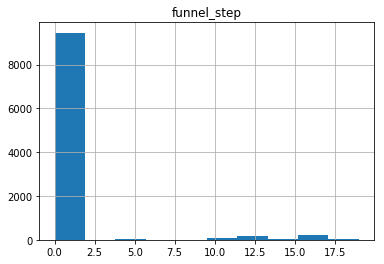

In [9]:
page.hist(column='funnel_step')

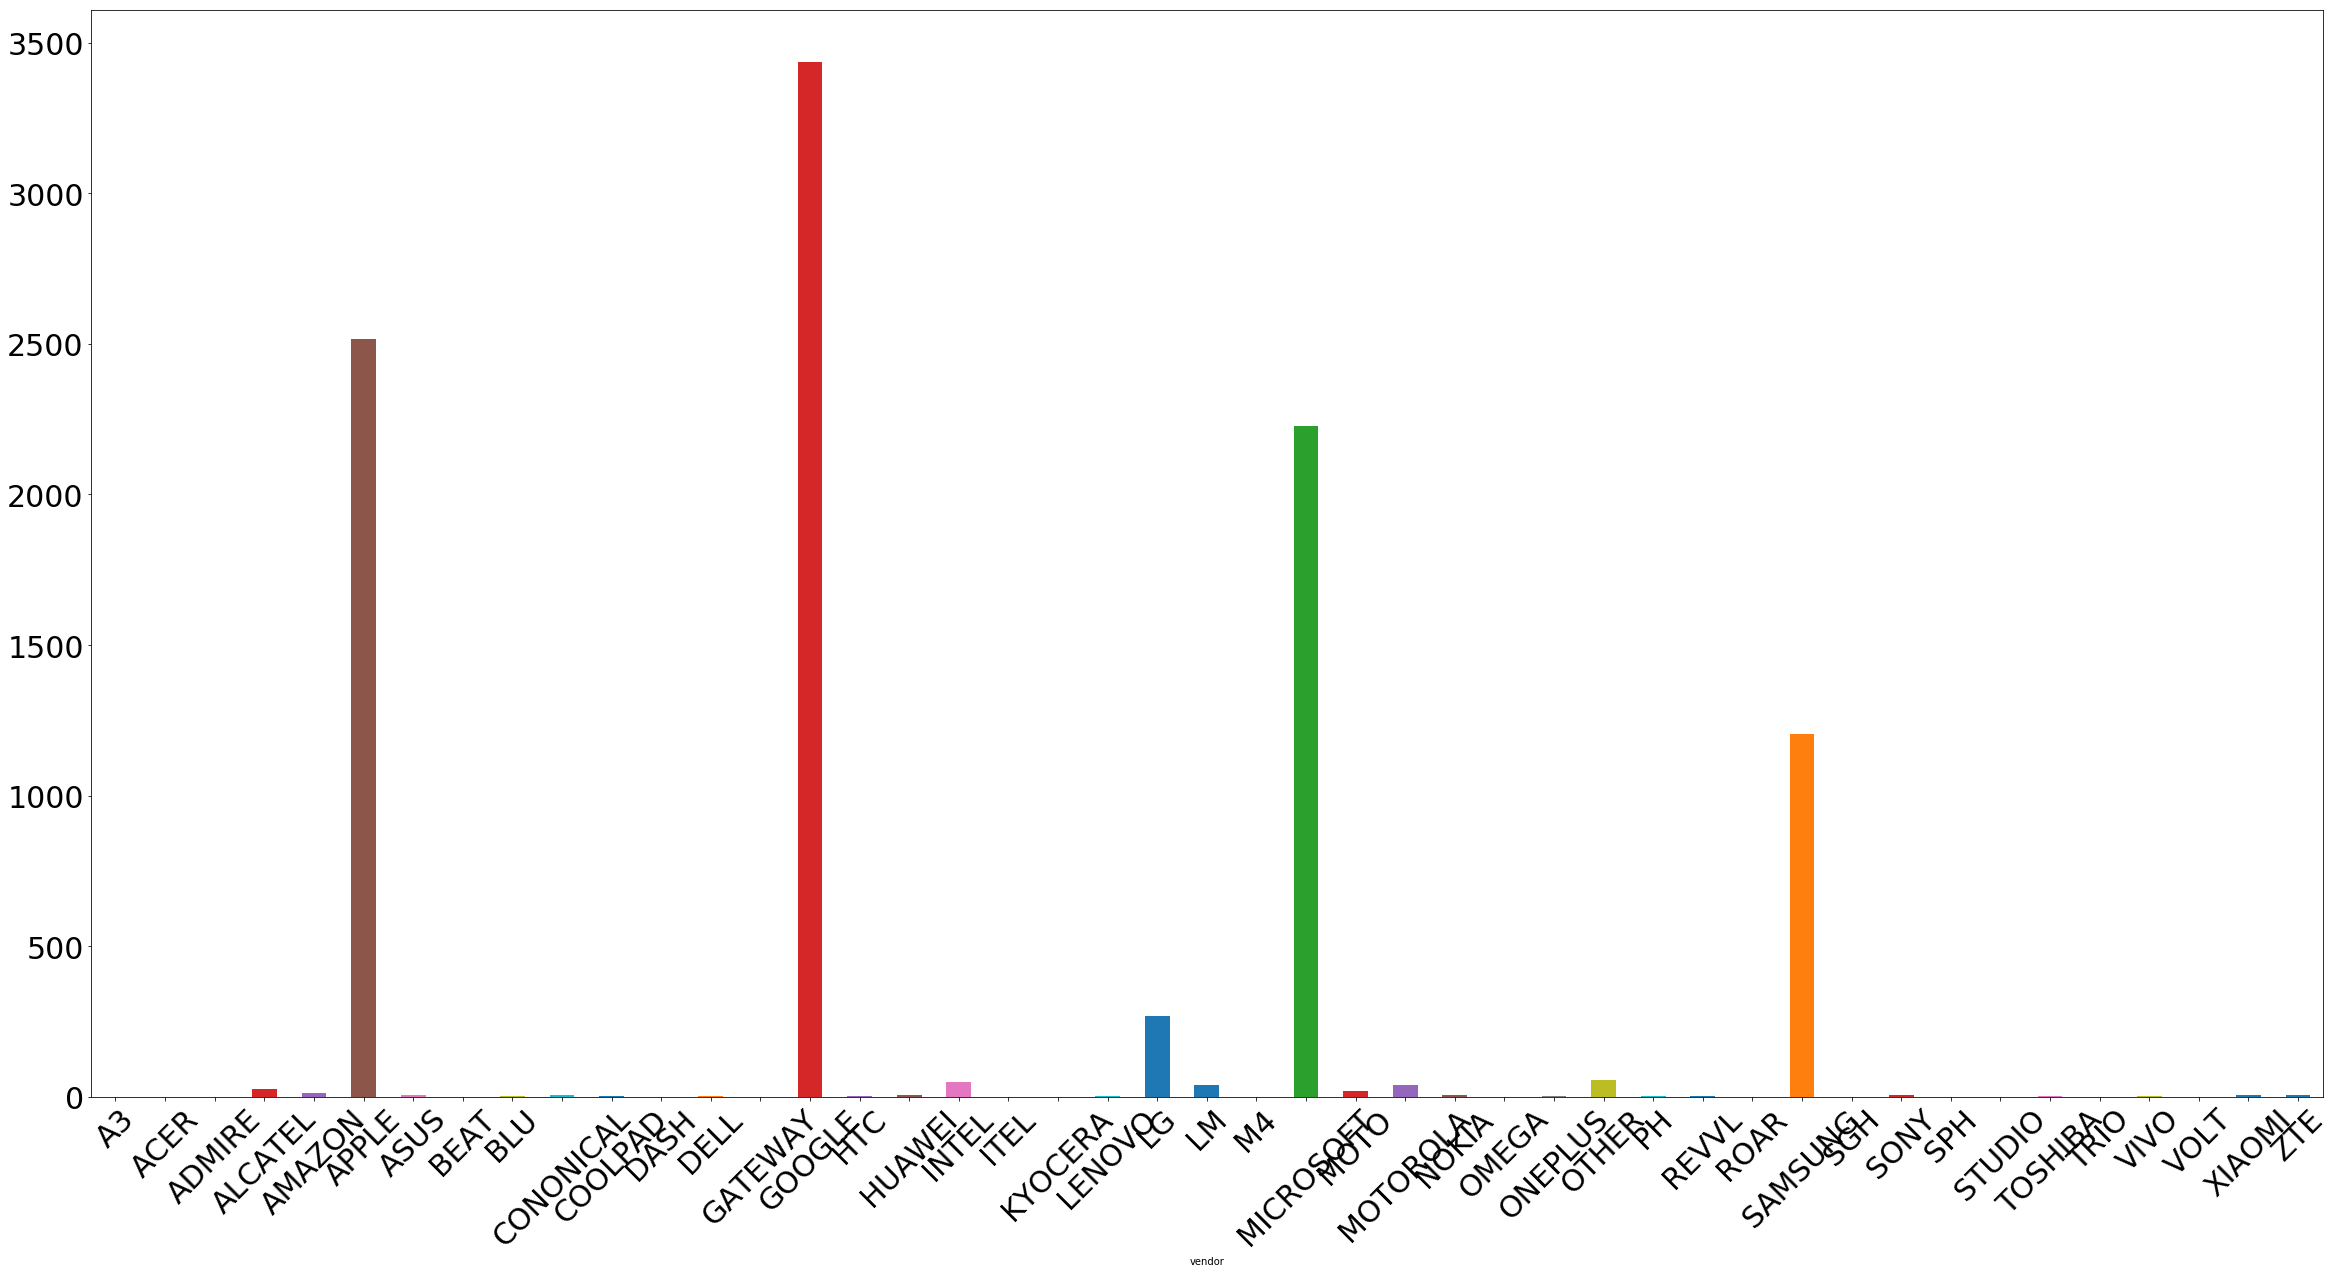

In [12]:
vendor = page.groupby('vendor').size()
vendor.columns = ['size']
ax = vendor.plot.bar(y='size', rot=45, figsize=(40,20), fontsize=30)
plt.show()

In [2]:
def chi_square(p1, p2):
    # Add missing indexes from p1 to p2, with count == 5.
    #p2 = pd.concat([p2, pd.DataFrame(5, index=p2_expected.index.difference(p2.index), columns=['total'])])
    
    # Chi-square statistics requires categories with more than 4 values.
    p1 = p1.loc[p1.total > 4]
    p2 = p2.loc[p2.total > 4]
    #Allign the dataframes to the same index
    p1 = p1.loc[set(p1.index).intersection(set(p2.index))]
    p2 = p2.loc[set(p1.index).intersection(set(p2.index))]
    #print(p1)
    #print(p2)

    #Calculate Chi square critical value and calculated Chi square statistics.
    p1_ratio = p1 / p1.total.sum()
    p2_expected = p1_ratio * p2.total.sum()
    crit = stats.chi2.ppf(q=0.95, df=(len(p2) - 1))
    chi_squared_stat = (((p2 - p2_expected) ** 2) / p2_expected).sum()
    chi_squared_stat2 = stats.chisquare(f_obs = p2, f_exp = p2_expected)
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=(len(p2) - 1))
    #print(f'Chi-square statistics: {chi_squared_stat2}, Critical value: {crit}')
    return chi_squared_stat, crit, p_value

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [15]:
for dimension in ['uabrowser_group', 'resolution_family', 'uadevicetype', 'vendor', 'country', 'os']:
    print(f'Dimension [{dimension}]:', end="")
    p1 = pd.crosstab(index=page.loc[page.funnel_step <= funnel_step_end][dimension], columns='total') # First population (all sessions).
    p2 = pd.crosstab(index=page.loc[page.funnel_step == funnel_step_end][dimension], columns='total') # Second population.
    chi_squared_stat, crit, p_value = chi_square(p1, p2)
    if(chi_squared_stat.total <= (1.2 * crit)):
        print(f' Chi-square statistics is lower than critical level, no significant population differnece.\n')
    elif(p_value <= 0.05):
        print(f' Chi-square statistics is significantly higher than critical level searching for candidate.\n',\
              f' Scores: chi-square:{chi_squared_stat.total}, critical:{crit}, p_value:{p_value[0]}')
        #Loop on all values. Search for one value that is causing H_0 to fail, i.e. without it either:
        #      1) critical value is lower than threshold, or
        #      2) p-value is higher than the threshold
        for candidate in p1.index.values:
            p1_temp = p1.loc[p1.index != candidate]
            p2_temp = p2.loc[p2.index != candidate]
            chi_squared_test, crit, p_score = chi_square(p1_temp, p2_temp)
            if(chi_squared_test.total < crit or p_value > 0.04):
                print(f'    Value {candidate} is breaking the test, need to report an alarm. Scores without this value: chi-square:{chi_squared_test.total}, critical:{crit}, p_value:{p_score[0]}')
                #sqlmsg = f"INSERT INTO alarms values ({t1}, '{uuid.uuid1()}', '{dimension}', 'Distribution of failed before and after steps', 1, 1, '{candidate}', '');commit;"
                #cur.execute(sqlmsg)
                #con.commit()
    else:
        print(f' No significant population difference.') #p_value is not small enough.
con.close()

Sun Apr 21 08:48:28 2019 Redshift connection Successful!
Checking funnel step 1 to 4. Selecting sessions from cs_table.
Dimension [uabrowser_group]: No significant population difference.
Dimension [resolution_family]: No significant population difference.
Dimension [uadevicetype]: Chi-square statistics is significantly higher than critical level searching for candidate.
  Scores: chi-square:8.732260925527829, critical:3.841458820694124, p_value:0.0031262859671006282
Dimension [vendor]: No significant population difference.
Dimension [country]: No significant population difference.
Dimension [os]: No significant population difference.
